11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch   1/500 – G_loss 0.5851  D_loss 1.4686
Epoch   2/500 – G_loss 0.7531  D_loss 1.1158
Epoch   3/500 – G_loss 0.9488  D_loss 0.9399
Epoch   4/500 – G_loss 1.1330  D_loss 0.8233
Epoch   5/500 – G_loss 1.2865  D_loss 0.7492
Epoch   6/500 – G_loss 1.3920  D_loss 0.7117
Epoch   7/500 – G_loss 1.4539  D_loss 0.6951
Epoch   8/500 – G_loss 1.4863  D_loss 0.6936
Epoch   9/500 – G_loss 1.4936  D_loss 0.7044
Epoch  10/500 – G_loss 1.4573  D_loss 0.7337
Epoch  11/500 – G_loss 1.3914  D_loss 0.7824
Epoch  12/500 – G_loss 1.3126  D_loss 0.8475
Epoch  13/500 – G_loss 1.2228  D_loss 0.9276
Epoch  14/500 – G_loss 1.1069  D_loss 1.0343
Epoch  15/500 – G_loss 0.9662  D_loss 1.1660
Epoch  16/500 – G_loss 0.8483  D_loss 1.2874
Epoch  17/500 – G_loss 0.7632  D_loss 1.3721
Epoch  18/500 – G_loss 0.7159  D_loss 1.4164
Epoch  19/500 – G_loss 0.6917  D_loss 1.4353
Epoch  20/500 – G_loss 0.6856  D_loss 1.4290
Epoch  21/500 – G_loss 0.6920  D_loss 1.4087
Epoch  22/500 – G_loss 0.6960  D_loss 1.3951
Epoch  23/

Epoch 500/500 – G_loss 1.4126  D_loss 1.0751
Generator saved to fcgan_generator.h5
Images written to gen_samples_fcgan/


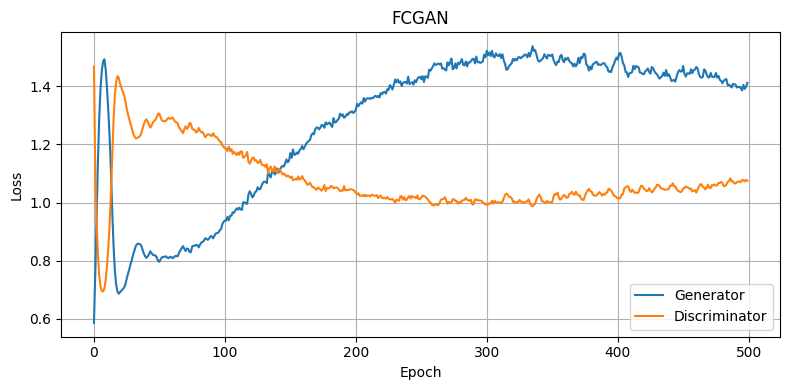

In [1]:
import tensorflow as tf
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras import layers
import matplotlib.pyplot as plt, numpy as np, imageio, pathlib, os

# Mixed Precision
tf.config.optimizer.set_jit(True)           # XLA
set_global_policy("mixed_float16")          # FP16 where safe

# Optional: make TF log less chatty
tf.get_logger().setLevel("ERROR")

# Data
(train_images, _), _ = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(-1, 28, 28, 1).astype("float32")
train_images = (train_images - 127.5) / 127.5        # [-1, 1]

BUFFER_SIZE = 60_000
BATCH_SIZE  = 4096  # big batch
train_ds = (tf.data.Dataset.from_tensor_slices(train_images)
            .cache()                                  # stays in RAM
            .shuffle(BUFFER_SIZE)
            .batch(BATCH_SIZE, drop_remainder=True)   # constant size
            .prefetch(tf.data.AUTOTUNE))

# 2. Model
LATENT_DIM = 100

def make_generator():
    return tf.keras.Sequential([
        # latent vector z  →  (LATENT_DIM,)
        layers.Input(shape=(LATENT_DIM,)),

        layers.Dense(256),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Dense(512),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Dense(1024),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # final layer: 28*28*1 units, then reshape to image
        layers.Dense(28 * 28, activation="tanh", dtype="float32"),
        layers.Reshape((28, 28, 1)),
    ], name="fcgan_generator")

def make_discriminator():
    return tf.keras.Sequential([
        layers.Input(shape=(28, 28, 1)),

        layers.Flatten(),

        layers.Dense(1024),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Dense(512),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Dense(256),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Dense(1, activation="sigmoid", dtype="float32"),  # logits → prob
    ], name="fcgan_discriminator")

generator     = make_generator()
discriminator = make_discriminator()

# 3. Loss & Optims
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def gen_loss(fake_out):
    return bce(tf.ones_like(fake_out), fake_out)

def disc_loss(real_out, fake_out):
    real_labels = tf.ones_like(real_out) * 0.9
    fake_labels = tf.zeros_like(fake_out)
    return bce(real_labels, real_out) + bce(fake_labels, fake_out)

g_opt = tf.keras.optimizers.Adam(2.5e-5, 0.5)  # keep master weights in FP32
d_opt = tf.keras.optimizers.Adam(2.5e-5, 0.5)

# 4. Train Step
@tf.function(jit_compile=True)           # extra hint for XLA
def train_step(real_imgs):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        fake_imgs = generator(noise, training=True)
        real_out  = discriminator(real_imgs, training=True)
        fake_out  = discriminator(fake_imgs, training=True)

        g_loss = gen_loss(fake_out)
        d_loss = disc_loss(real_out, fake_out)

    g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
    d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
    g_opt.apply_gradients(zip(g_grads, generator.trainable_variables))
    d_opt.apply_gradients(zip(d_grads, discriminator.trainable_variables))
    return g_loss, d_loss

# 5. Helper ‑ Images
def save_grid(images, path, cols=5):
    imgs = (images + 1) / 2.0
    rows = (len(imgs) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    axes = axes.flatten()
    for i, img in enumerate(imgs):
        axes[i].imshow(img[:, :, 0], cmap="gray")
        axes[i].axis("off")
    for ax in axes[len(imgs):]:
        ax.axis("off")
    plt.tight_layout()
    plt.savefig(path, dpi=150)
    plt.close()

def generate_and_save(generator, num_samples=25, out_dir="gen_samples_fcgan"):
    pathlib.Path(out_dir).mkdir(exist_ok=True)
    noise = tf.random.normal([num_samples, LATENT_DIM])
    gen   = generator(noise, training=False)
    gen   = (gen + 1) / 2.0

    for i, img in enumerate(gen):
        img_u8 = tf.image.convert_image_dtype(img, tf.uint8)
        imageio.imwrite(f"{out_dir}/digit_{i:04d}.png", img_u8.numpy().squeeze())

    save_grid(gen.numpy(), f"{out_dir}/grid.png")

# 6. Training Loop
EPOCHS = 500
g_losses, d_losses = [], []

for epoch in range(EPOCHS):
    g_tot = d_tot = batches = 0
    for batch in train_ds:
        g_loss, d_loss = train_step(batch)
        g_tot += g_loss
        d_tot += d_loss
        batches += 1

    g_losses.append(g_tot / batches)
    d_losses.append(d_tot / batches)
    print(f"Epoch {epoch+1:3d}/{EPOCHS} – "
          f"G_loss {g_losses[-1]:6.4f}  D_loss {d_losses[-1]:6.4f}")

# 7. Post‑Training
generator.save("fcgan_generator.h5")
print("Generator saved to fcgan_generator.h5")

generate_and_save(generator, num_samples=25)
print("Images written to gen_samples_fcgan/")

# Loss curves (quick sanity)
plt.figure(figsize=(8,4))
plt.plot(g_losses, label="Generator")
plt.plot(d_losses, label="Discriminator")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("FCGAN")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


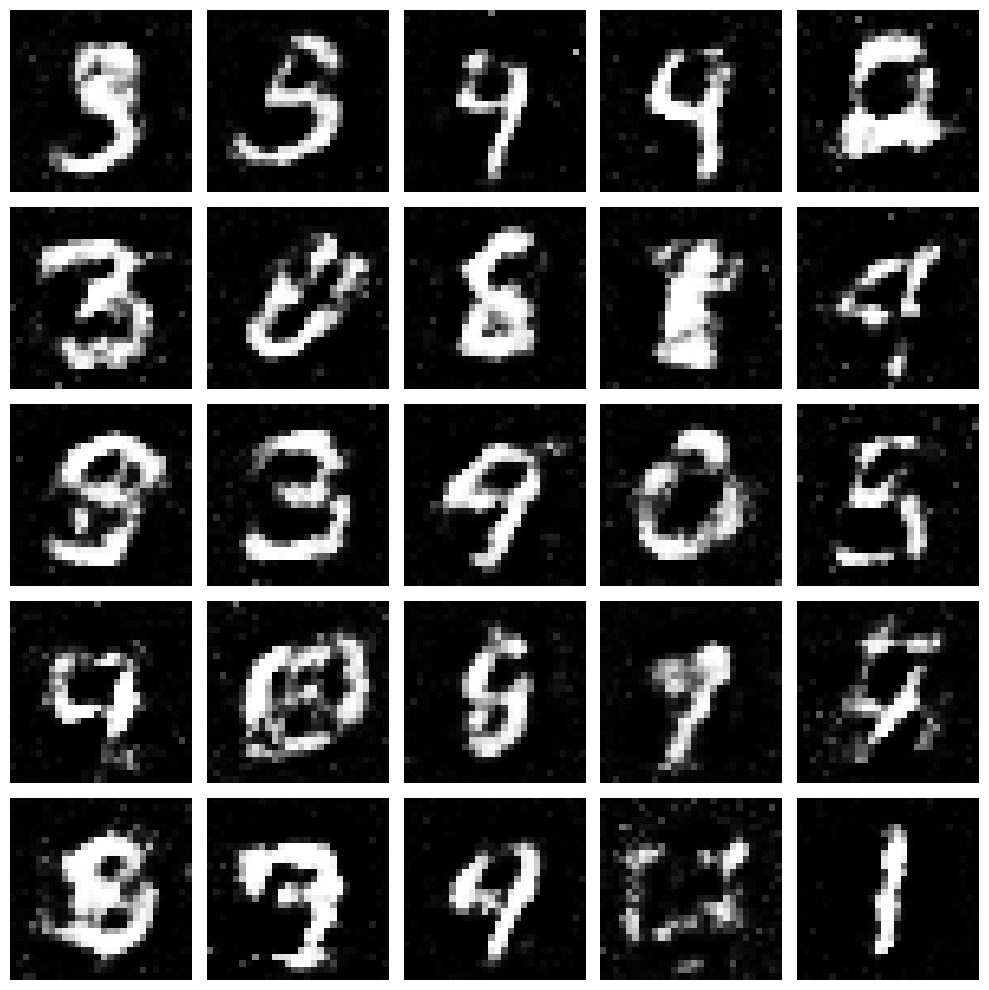

In [2]:
# 8. Quick Preview
LATENT_DIM = 100
N_SHOW     = 25           # Number of images to display
COLS       = 5            # grid columns

def sample_and_show(gen_model, n=N_SHOW, cols=COLS):
    noise = tf.random.normal([n, LATENT_DIM])
    imgs  = gen_model(noise, training=False)
    imgs  = (imgs + 1) / 2.0        # → [0,1] float32

    rows = (n + cols - 1) // cols
    plt.figure(figsize=(cols * 2, rows * 2))
    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(imgs[i, :, :, 0], cmap="gray")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# 1) If you just finished training, `generator` is already in memory:
sample_and_show(generator)

# 2) If you’re in a fresh session, first reload the saved model:
# generator = tf.keras.models.load_model("fcgan_generator.h5", compile=False)
# sample_and_show(generator)
